In [1]:
#import library
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import IPython.display as ipd
import librosa
import librosa.display
from scipy.io import wavfile as wav
from scipy import signal
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

%matplotlib inline

**Batas**

In [2]:
wav_file = "../input/data-burung/essential_data/src_wavs/PC10_20090513_054500_0010.wav"

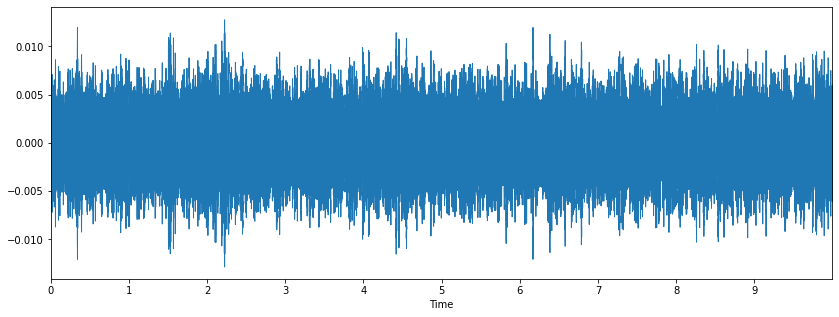

In [3]:
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(wav_file)
librosa.display.waveplot(data, sr=sample_rate)
ipd.Audio(wav_file)

In [4]:
n_fft=2048
hop_length=512
# Short-time Fourier transform 
D_astfly = np.abs(librosa.stft(data, n_fft = n_fft, hop_length = hop_length))
# Merubah amplitudo spectrogram menjadi Decibels-scaled spectrogram.
DB_astfly = librosa.amplitude_to_db(D_astfly, ref = np.max)

fig = plt.Figure()
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)
img=librosa.display.specshow(DB_astfly, sr = sample_rate, hop_length = hop_length, x_axis = 'time', y_axis = 'log', ax=ax)
fig.savefig('spectrogram.png')

In [5]:
sample_rate

22050

In [6]:
data

array([-2.2813038e-03, -1.5172369e-03, -2.1276664e-04, ...,
       -9.8856085e-04, -6.8078772e-04,  6.4550804e-05], dtype=float32)

In [7]:
species = pd.read_csv('../input/data-burung/essential_data/species_list.txt')
species

,class_id,code,species
0,0,BRCR,Brown Creeper
1,1,PAWR,Pacific Wren
2,2,PSFL,Pacific-slope Flycatcher
3,3,RBNU,Red-breasted Nuthatch
4,4,DEJU,Dark-eyed Junco
5,5,OSFL,Olive-sided Flycatcher
6,6,HETH,Hermit Thrush
7,7,CBCH,Chestnut-backed Chickadee
8,8,VATH,Varied Thrush
9,9,HEWA,Hermit Warbler


In [8]:
file_name = pd.read_csv('../input/data-burung/essential_data/rec_id2filename.txt')
file_name

,rec_id,filename
0,0,PC1_20090513_050000_0010
1,1,PC1_20090513_070000_0010
2,2,PC1_20090606_050012_0010
3,3,PC1_20090606_070012_0010
4,4,PC1_20090705_050000_0010
...,...,...
640,640,PC18_20100513_043000_0750
641,641,PC18_20100705_050000_0040
642,642,PC18_20100705_070000_0040
643,643,PC18_20100804_050020_0040


In [9]:
id_ls = []
label_ls = []

num_species = 19
raw =  pd.read_csv('../input/data-burung/essential_data/rec_labels_test_hidden.txt', sep = ';')
label = np.zeros([len(raw),num_species])
for i in range(len(raw)):
    line = raw.iloc[i]
    labels = line[0].split(',')
    id_ls.append(labels.pop(0))
    if len(labels) != 0:
        label_ls.append(labels[0])
    else:
#         label_ls.append(np.nan)
        label_ls.append(-1)

label_df = pd.DataFrame(list(zip(id_ls, label_ls)), columns =['rec_id', 'label'])
label_df

,rec_id,label
0,0,?
1,1,?
2,2,11
3,3,-1
4,4,?
...,...,...
640,640,8
641,641,4
642,642,4
643,643,?


In [10]:
folds = pd.read_csv('../input/data-burung/essential_data/CVfolds_2.txt')
folds

,rec_id,fold
0,0,1
1,1,1
2,2,0
3,3,0
4,4,1
...,...,...
640,640,0
641,641,0
642,642,0
643,643,1


In [11]:
bird_df = pd.DataFrame()
bird_df['rec_id'] = file_name['rec_id'].values
bird_df['filename'] = file_name['filename'].values
bird_df['label'] = label_df['label']
bird_df['fold'] = folds['fold'].values

In [12]:
bird_df.loc[bird_df['fold'] == 1]

,rec_id,filename,label,fold
0,0,PC1_20090513_050000_0010,?,1
1,1,PC1_20090513_070000_0010,?,1
4,4,PC1_20090705_050000_0010,?,1
6,6,PC1_20090804_050011_0010,?,1
7,7,PC1_20090804_070012_0010,?,1
...,...,...,...,...
637,637,PC18_20090804_050000_0040,?,1
638,638,PC18_20090804_070000_0040,?,1
639,639,PC18_20100513_043000_0040,?,1
643,643,PC18_20100804_050020_0040,?,1


In [13]:
data_ls = []
samplenr_ls = []
# sample_ls = []
for name in file_name["filename"]:
    data, samplenr_rate = librosa.load(r'../input/data-burung/essential_data/src_wavs/'+str(name)+'.wav')
#     sample_rate, samples = wav.read(r'../input/data-burung/essential_data/src_wavs/'+str(name)+'.wav')
    data_ls.append(data)
    samplenr_ls.append(samplenr_rate)
#     sample_ls.append(sample_rate)

In [14]:
# wav_df = pd.DataFrame()
# bird_df['rec_id'] = file_name["rec_id"].values
# bird_df['filename'] = file_name["filename"].values
bird_df['feature'] = data_ls
bird_df['norm_sample_rate'] = samplenr_ls
# bird_df['sample_rate'] = sample_ls
# wav_df = wav_df.reset_index(drop=True)
bird_df

,rec_id,filename,label,fold,feature,norm_sample_rate
0,0,PC1_20090513_050000_0010,?,1,"[0.00082150096, 0.0015201834, 0.0016857148, 0....",22050
1,1,PC1_20090513_070000_0010,?,1,"[0.0032472524, 0.0044063386, 0.0029937953, 0.0...",22050
2,2,PC1_20090606_050012_0010,11,0,"[-0.00017401505, 0.000374372, 0.0015390213, 0....",22050
3,3,PC1_20090606_070012_0010,-1,0,"[0.00028723487, -0.0006757142, -0.0023610783, ...",22050
4,4,PC1_20090705_050000_0010,?,1,"[-1.22156835e-05, -0.0011563431, -0.0023585062...",22050
...,...,...,...,...,...,...
640,640,PC18_20100513_043000_0750,8,0,"[0.005707883, 0.005771529, 0.0029862104, 0.002...",22050
641,641,PC18_20100705_050000_0040,4,0,"[-0.002366838, -0.0023866661, -0.0014909052, -...",22050
642,642,PC18_20100705_070000_0040,4,0,"[-0.0016293589, -0.0014698908, -0.0019722772, ...",22050
643,643,PC18_20100804_050020_0040,?,1,"[-0.0006584903, -0.0014040298, -0.0014328553, ...",22050


In [15]:
bird_df.shape

(645, 6)

In [16]:
bird_train_df = bird_df.loc[bird_df['fold'] == 0]
bird_train_df = bird_train_df.reset_index(drop=True)
bird_test_df = bird_df.loc[bird_df['fold'] == 1]
bird_test_df = bird_test_df.reset_index(drop=True)
# bird_test_df['label'] = np.nan

In [17]:
bird_train_df

,rec_id,filename,label,fold,feature,norm_sample_rate
0,2,PC1_20090606_050012_0010,11,0,"[-0.00017401505, 0.000374372, 0.0015390213, 0....",22050
1,3,PC1_20090606_070012_0010,-1,0,"[0.00028723487, -0.0006757142, -0.0023610783, ...",22050
2,5,PC1_20090705_070000_0010,10,0,"[0.001378088, 0.0017611425, 0.0011195702, 0.00...",22050
3,8,PC1_20100513_043000_0010,-1,0,"[0.0011536721, -0.00057992194, -0.003347162, -...",22050
4,9,PC1_20100513_043000_0720,-1,0,"[0.0037170437, 0.0063757286, 0.005971008, 0.00...",22050
...,...,...,...,...,...,...
317,633,PC17_20100804_050020_0040,-1,0,"[0.0016848102, 0.0010299982, 0.0001427261, 0.0...",22050
318,634,PC17_20100804_070020_0040,0,0,"[0.001490283, 0.0022308119, 0.0022353898, 0.00...",22050
319,640,PC18_20100513_043000_0750,8,0,"[0.005707883, 0.005771529, 0.0029862104, 0.002...",22050
320,641,PC18_20100705_050000_0040,4,0,"[-0.002366838, -0.0023866661, -0.0014909052, -...",22050


In [18]:
bird_test_df

,rec_id,filename,label,fold,feature,norm_sample_rate
0,0,PC1_20090513_050000_0010,?,1,"[0.00082150096, 0.0015201834, 0.0016857148, 0....",22050
1,1,PC1_20090513_070000_0010,?,1,"[0.0032472524, 0.0044063386, 0.0029937953, 0.0...",22050
2,4,PC1_20090705_050000_0010,?,1,"[-1.22156835e-05, -0.0011563431, -0.0023585062...",22050
3,6,PC1_20090804_050011_0010,?,1,"[-0.0004567776, -0.00031149882, -0.00062465627...",22050
4,7,PC1_20090804_070012_0010,?,1,"[-0.0024989431, -0.0029619902, -0.0021018663, ...",22050
...,...,...,...,...,...,...
318,637,PC18_20090804_050000_0040,?,1,"[0.0023919914, 0.0032594854, 0.0027111578, 0.0...",22050
319,638,PC18_20090804_070000_0040,?,1,"[0.0010506413, 0.0010480254, 0.0016802507, 0.0...",22050
320,639,PC18_20100513_043000_0040,?,1,"[0.00016013588, -0.00012685366, -0.00040712891...",22050
321,643,PC18_20100804_050020_0040,?,1,"[-0.0006584903, -0.0014040298, -0.0014328553, ...",22050


In [19]:
bird_df['label'].value_counts(normalize=True)

?     0.500775
-1    0.221705
1     0.054264
10    0.029457
6     0.026357
9     0.024806
8     0.023256
2     0.021705
4     0.017054
7     0.015504
18    0.012403
0     0.010853
11    0.006202
13    0.006202
5     0.006202
17    0.006202
14    0.004651
15    0.003101
16    0.003101
12    0.003101
3     0.003101
Name: label, dtype: float64

In [20]:
def extract_features(filename):
    
    # Sets the name to be the path to where the file is in my computer
#     file_name = os.path.join(os.path.abspath('voice')+'/'+str(filename))

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
#     data, samplenr_rate = librosa.load(r'../input/data-burung/essential_data/src_wavs/'+str(name)+'.wav')
    X, sample_rate = librosa.load(r'../input/data-burung/essential_data/src_wavs/'+str(filename)+'.wav', res_type='kaiser_fast')
#     X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    label = filename

    return mfccs, chroma, mel, contrast, tonnetz, label

In [21]:
features_label = bird_train_df['filename'].apply(extract_features)
features_test = bird_test_df['filename'].apply(extract_features)

/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [22]:
features_test

0      ([-396.6265, 155.5182, -85.09692, 70.890366, -...
1      ([-396.26718, 152.78064, -84.34494, 69.199135,...
2      ([-492.92502, 122.12748, -71.23293, 84.12028, ...
3      ([-518.73816, 125.9309, -60.363056, 74.102234,...
4      ([-524.8687, 134.07626, -67.734505, 80.58145, ...
                             ...                        
318    ([-532.60956, 109.22956, -54.462257, 70.8126, ...
319    ([-524.7339, 119.3467, -51.77346, 73.021065, -...
320    ([-457.62, 135.3008, -50.288586, 49.141125, -2...
321    ([-523.6033, 117.89686, -57.128983, 73.16097, ...
322    ([-531.75006, 129.12407, -68.420586, 82.46871,...
Name: filename, Length: 323, dtype: object

In [23]:
features = []
for i in range(len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))

features_test_ls = []
for i in range(len(features_test)):
    features_test_ls.append(np.concatenate((features_test[i][0], features_test[i][1], 
                features_test[i][2], features_test[i][3],
                features_test[i][4]), axis=0))

In [24]:
len(features)

322

In [25]:
X = np.array(features)
X_test = np.array(features_test_ls)
y = np.array(bird_train_df['label'].astype('int'))

In [26]:
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))

In [27]:
X_test.shape

(323, 193)

In [28]:
X.shape

(322, 193)

In [29]:
y.shape

(322, 20)

In [30]:
X_train = X[:257]
y_train = y[:257]

X_val = X[257:]
y_val = y[257:]

In [31]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [32]:
model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(20, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [33]:
history = model.fit(X_train, y_train, batch_size=5, epochs=10,validation_data=(X_val, y_val), callbacks=[early_stop])

2021-10-26 19:39:31.819993: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
52/52 [==============================] - 1s 7ms/step - loss: 2.7354 - accuracy: 0.3152 - val_loss: 1.9199 - val_accuracy: 0.5538
Epoch 2/10
52/52 [==============================] - 0s 3ms/step - loss: 2.1144 - accuracy: 0.4669 - val_loss: 1.7926 - val_accuracy: 0.5538
Epoch 3/10
52/52 [==============================] - 0s 3ms/step - loss: 1.9016 - accuracy: 0.5058 - val_loss: 1.7732 - val_accuracy: 0.5538
Epoch 4/10
52/52 [==============================] - 0s 3ms/step - loss: 1.8120 - accuracy: 0.5214 - val_loss: 1.7166 - val_accuracy: 0.5385
Epoch 5/10
52/52 [==============================] - 0s 3ms/step - loss: 1.8332 - accuracy: 0.5136 - val_loss: 1.7137 - val_accuracy: 0.5538
Epoch 6/10
52/52 [==============================] - 0s 3ms/step - loss: 1.6957 - accuracy: 0.5447 - val_loss: 1.6767 - val_accuracy: 0.5846
Epoch 7/10
52/52 [==============================] - 0s 4ms/step - loss: 1.5613 - accuracy: 0.5759 - val_loss: 1.7078 - val_accuracy: 0.5846
Epoch 8/10
52/52 [==

In [34]:
preds = model.predict(X_test)
preds

array([[7.7616745e-01, 4.9666185e-03, 1.6662167e-02, ..., 5.4370868e-04,
        1.3477288e-03, 1.0731631e-02],
       [8.2027078e-01, 4.0651252e-03, 1.3107664e-02, ..., 4.5824342e-04,
        1.1093991e-03, 8.2733277e-03],
       [3.1523462e-06, 9.9550952e-08, 9.9770290e-01, ..., 5.3755979e-08,
        9.8942550e-08, 1.0295681e-05],
       ...,
       [4.5150873e-01, 7.5498191e-03, 3.9691079e-02, ..., 4.9182154e-02,
        4.9082092e-03, 1.1816542e-02],
       [8.8869286e-01, 6.6885017e-03, 1.5322503e-03, ..., 6.0847535e-04,
        3.8160302e-03, 7.5351563e-03],
       [8.4275210e-01, 1.3910384e-02, 3.2588956e-03, ..., 4.4933916e-04,
        5.5906391e-03, 1.2663911e-02]], dtype=float32)

In [35]:
label_pred = np.argmax(preds, axis=1)
label_pred

array([ 0,  0,  2,  0,  0,  0, 11,  0,  0,  2, 11, 11,  0,  2,  0,  0,  0,
        2,  0,  0,  0,  9, 19,  0, 10, 19,  0,  0,  0,  0,  0,  0,  0,  0,
        2,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,
       14,  0,  0,  0,  0,  0,  0,  8,  0,  0,  7,  2,  0,  0,  9,  0,  0,
        7,  0,  0,  0,  0,  0,  0,  5, 10,  0,  0,  0,  0,  7,  0,  0,  0,
        2,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  2,  2,  2,  0,  2,  0,
       11, 11,  0, 11,  2,  0, 10,  0,  0,  0,  5,  0,  0, 10,  0,  0,  0,
        2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0, 14,  2,  7,
       14,  0,  0,  0,  2,  0,  9,  2,  0,  0,  0,  9,  2,  8,  8,  9,  0,
        0,  7,  0,  0,  0,  6,  0,  0,  0,  9,  0,  0,  6,  2,  9,  0,  0,
        5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  2,  0,  0,  2,
        0,  2, 11,  2,  0,  0, 11, 11, 11, 11,  0,  5, 10,  0,  0,  5,  0,
        0,  0,  0,  0,  0,  0,  0,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,
        5,  0,  0,  2,  2

In [36]:
len(label_pred)

323

In [37]:
bird_test_df['label'] = label_pred
bird_test_df

,rec_id,filename,label,fold,feature,norm_sample_rate
0,0,PC1_20090513_050000_0010,0,1,"[0.00082150096, 0.0015201834, 0.0016857148, 0....",22050
1,1,PC1_20090513_070000_0010,0,1,"[0.0032472524, 0.0044063386, 0.0029937953, 0.0...",22050
2,4,PC1_20090705_050000_0010,2,1,"[-1.22156835e-05, -0.0011563431, -0.0023585062...",22050
3,6,PC1_20090804_050011_0010,0,1,"[-0.0004567776, -0.00031149882, -0.00062465627...",22050
4,7,PC1_20090804_070012_0010,0,1,"[-0.0024989431, -0.0029619902, -0.0021018663, ...",22050
...,...,...,...,...,...,...
318,637,PC18_20090804_050000_0040,0,1,"[0.0023919914, 0.0032594854, 0.0027111578, 0.0...",22050
319,638,PC18_20090804_070000_0040,0,1,"[0.0010506413, 0.0010480254, 0.0016802507, 0.0...",22050
320,639,PC18_20100513_043000_0040,0,1,"[0.00016013588, -0.00012685366, -0.00040712891...",22050
321,643,PC18_20100804_050020_0040,0,1,"[-0.0006584903, -0.0014040298, -0.0014328553, ...",22050


In [38]:
submission = pd.read_csv('../input/data-burung/essential_data/sample_submission.csv')
submission

,rec_id,species,probability
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
6132,644,14,0
6133,644,15,0
6134,644,16,0
6135,644,17,0


In [39]:
submission.loc[(submission['rec_id'] == 0) & (submission['species'] == 0), 'probability']

0    0
Name: probability, dtype: int64

In [40]:
for i, row in bird_test_df.iterrows():
    submission.loc[(submission['rec_id'] == row['rec_id']) & (submission['species'] == row['label']), 'probability'] = 1
#     submission[(submission['rec_id'] == row['rec_id']) & (submission['species'] == row['label'])]['probability'] = 1

submission

,rec_id,species,probability
0,0,0,1
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
6132,644,14,0
6133,644,15,0
6134,644,16,0
6135,644,17,0


In [41]:
submission[(submission['probability'] == 1)]

,rec_id,species,probability
0,0,0,1
19,1,0,1
40,4,2,1
57,6,0,1
76,7,0,1
...,...,...,...
6042,637,0,1
6061,638,0,1
6080,639,0,1
6099,643,0,1


In [42]:
# submission.loc[submission['species'] == 1, 'probability'] = 1
submission.insert(0, "id", (submission["rec_id"] * 100) + submission["species"])
submission = submission.drop(['rec_id', 'species'], axis=1)
submission

,id,probability
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
6132,64414,0
6133,64415,0
6134,64416,0
6135,64417,0


In [43]:
submission.to_csv('submission.csv', index=False)